# **`PyDEns`**: basic PDE solving

Welcome! In this tutorial you'll learn how to solve partial differential equations (PDEs) with neural networks using **`PyDEns`**-model. We strongly encourage you to take a look at [theory behind **`PyDEns`**](./0.%20Theory.ipynb) before proceding to have some understanding about used math. This notebook
* starts with general [setup](#setup) of the PDE solved by **`PyDEns`**
* then explains in detail how various parts of the model are [configured](#configuration): [equation itself](#equation), [neural network architecture](#nn), [point-generating strategy](#sampler)
* finally, demonstrates how to use the model for solving common pde-problems, including *[heat-equation](https://en.wikipedia.org/wiki/Heat_equation)* and *[wave-equation](https://en.wikipedia.org/wiki/Wave_equation)*

To get full understanding of configuring process, we suggest you to read this tutorial starting from the very beginning. On the other hand, you can jump straight to the working examples:
* [first-order ode $\mathcal{R}$](#ex1)
* [poisson equation in $\mathcal{R}^2$](#ex2)
* [heat equation in $\mathcal{R}^2 \times \mathcal{R}$](#ex3)
* [wave equation in $\mathcal{R}$](#ex4)
* [equation with non-constant coefficients in $\mathcal{R}$](#ex5)
* [system of two equations in $\mathcal{R}$](#ex6)

**Note**: **`PyDEns`** is written in [**TensorFlow**](https://www.tensorflow.org/). Throughout the notebook `tf` will stand for **`TensorFlow`**.

<a id='setup'></a>
## Setup of the PDE-problem

With **`PyDEns`** one can solve almost any conceivable functional equation. Still, the model is most suited for solving evolution PDEs of up to the second order with boundary and initial conditions. In general form, we are set to find $u: \mathcal{R}^n \rightarrow \mathcal{R}$ that satisfies following constraints:

$$ F\left(u; t, x; \nabla u; \nabla^2 u; ...\right) = 0, $$

where $x$ is a $n$-dimensional vector, $t$ is time variable, which can be absent, and $F$ is some general functional. We use $\nabla u$, $\nabla^2 u$ to denote set of partial derivatives of the function of the first/second order respectively.

In order to make the solution unique, we must impose ***boundary*** and/or ***initial*** conditions

$$ \left. u(x, t) \right\rvert_{x \in \partial\Omega} = g(x, t), $$

$$  u(x, t_0) = u_0(x), $$

$$  \left. \frac{\partial u(x, t)}{\partial t} \right\rvert_{t = t_0} = u_1(x). $$

The problem is solved on rectangular domain
<a id='dom'></a>
$$
\Omega = [g_0^1, g_1^1] \times \dots \times [g_0^n, g_1^n] ,\quad u: \mathcal{R}^n \rightarrow \mathcal{R}
$$

<a id='configuration'></a>
## Setup of the PDE-problem

In order to communicate this problem to our framework, we must define three components: ***equation itself,*** ***model architecture*** and ***sampler of points.***

<a id='equation'></a>
### Equation

One of the goals of this framework is to be able to work with wide range of equations. That is why we have developed our **syntax**, that allows to communicate mathematical expressions with **`PyDEns`** in almost the same way that we use in everyday life. For example, to solve 
$$
\frac{d f}{d t} - 2\pi\cos[2 \pi t] = 0,
$$

one should write
```python
lambda u, t: D(u, t) - 2 * np.pi * cos(2 * np.pi * t)
```
Equation must be defined as a function, the first arguments of which correspond to unknown function(s), after which variables follow. In this case, we only have one function `u` and one independent variable `t`, so that is all we need to define. Note that exact names of the arguments don't matter: we could replace `t` with virtually any other valid `Python` name.

`D` stands for differential operator and allows us to get derivatives of the first argument w.r.t. the second. If this function is called with one argument, it returns list of derivatives along each of the arguments, which is, essentially, a gradient of the input function. We also have handy functions for divergence, laplace operator and many more. Also, you can see that we directly use `cos` operator in the code above. Obviously, it would be a pain to manually import all the necessary functions into the current namespace, so we provide a convenient `add_tokens` method: it automatically includes many of often used operators like `sin`, `cos`, `exp` to currently available objects. Under the hood each of our tokens is translated to their `tf` counterparts, together with doing some inner workings of **`PyDEns`**.

***Boundary*** and ***initial*** conditions are defined in the same vein: the same syntax rules do apply, so we can be flexible in defining PDE constraints.

**Note:** one more thing should be added to configuration: `n_dims` — number of input variables of the solution. Clearly, we can fetch the dimensionality from the equation definition; yet, it is better to explicitly articulate some of the key parameters.

<a id='nn'></a>
### Defining neural approximator

We heavily rely on [**BatchFlow**](https://github.com/analysiscenter/batchflow) to define complex neural network architectures in just a few lines of code. For instance, 
```python
'body':{'layout' : 'fa fa f',
        'units' : [10, 15, 1],
        'activation' : tf.nn.tanh}
```
corresponds to a `f`ully-connected network with two hidden layers (of 10 and 15 units), one output-unit and two `tanh`- `a`ctivations. There is a [wealth](https://github.com/analysiscenter/batchflow/tree/master/examples/tutorials) of examples, that we definetely recommend looking at.

We also provide default neural network configuration: it automatically adjusts its size to the problem dimensionality and can be used as very simple baseline.

<a id='sampler'></a>
### Data-feeding procedure

To conveniently generate batches of points we employ [**Sampler**](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/07_sampler.ipynb) class from **`BatchFlow`**. It allows to create complex distributions, combine them as mixtures, concatenate, and many more. For example, we can use the line:
```python
s = (0.5 + NumpySampler('normal', dim=2)).truncate((1, 1), (0, 0)) 
```
to create 2-dimensional Gaussian with center at $(0.5, 0.5)$, truncated into unit square.

<a id='adds'></a>
### Additional options

Quite often, we'd like to get not only the solution values,  but also values of derivatives or any other expression on the solution and coordinates. The `track` key does exactly that: you can define custom names and assign mathematical expressions, written in our syntax to them. For example, we can track the time-derivatives with:
```python
'dt': lambda u, t: D(u, t)
```

There are a lot of other parameters that define either training procedure, or completely change the approximator. Some of them are:

* `loss` allows to swap error-function from default `MSE` to any other
* `bind_bc_ic` indicates whether we should use [ansatz](./0.%20Theory.ipynb) or not
* `time_multiplier` controls the ansatz type, as was explained in the [theory](./0.%20Theory.ipynb)
* `decay` stands for learning rate decay schedule, and allows for faster convergence
* `train_steps` grants ability to dynamically swap losses, optimizers and decays at train time. It can also be used to alternate between optimizing various parts of the neural network. This key is heavily used (and in-depth explained) in the [advanced tutorial](./2.%20Advanced%20PyDEns.ipynb)

<a id='wrapper'></a>
### Putting it all together

Finally, we use **Solver** to contain all the given information. Training a model is just a matter of calling `fit` method with for desired number of iterations:
```python
dg = Solver(config)
dg.fit(batch_size=150, sampler=s, n_iters=1500, bar='notebook')
```

## Examples: Solving common PDEs with **`PyDEns`**

In [1]:
import os
import sys

# Stop TF from showing unnecessary deprecation warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

sys.path.append('..') # this line is not needed if PyDEns is installed as package
from pydens import Solver, NumpySampler, cart_prod, add_tokens
from utils import plot_loss

<a id='tokens'></a>

As was mentioned earlier, we have custom language to define PDE's. To use it, execute following code:

In [2]:
add_tokens()

It automatically adds names like `sin`, `cos`, `exp` to current namespace, allowing to use it without cluttering your code with things like `tf.sin`, `torch.cos`, `np.exp`.

**Note**: by default, all of the functions are **Tensorflow** ones. To change this (for example, to swap to **PyTorch**), pass `module` argument to `add_tokens`.

<a id='ex1'></a>
###  First-order ordinary differential equation in $\mathcal{R}$ with simple initial condition
$$
\frac{d u}{d t}= 2\pi\cos[2 \pi t];
$$

$$
t \in [0, 1],
$$

$$
u(0)=1.
$$

In [3]:
# describing pde-problem in pde-dict
pde = {'n_dims': 1,
       'form': lambda u, t: D(u, t) - 2 * np.pi * cos(2 * np.pi * t),
       'initial_condition': 1,
      }

# put it together in model-config
config = {'pde': pde,
          'track': {'dt': lambda u, t: D(u, t)}}

# uniform sampling scheme
s = NumpySampler('uniform')

In [4]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=100, sampler=s, n_iters=2000, bar='notebook')

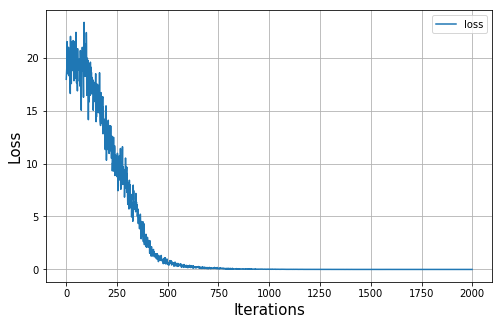

In [5]:
plot_loss(dg.loss)

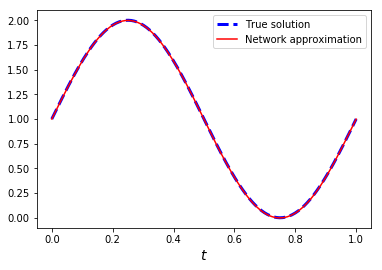

In [6]:
# plot real solution and network approximation
sol = lambda t: np.sin(2 * np.pi * t) + 1
pts = np.linspace(0, 1, 200).reshape(-1, 1)
approxs = dg.solve(pts)
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b--', linewidth=3, label='True solution')
plt.plot(pts, approxs, 'r', label='Network approximation')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

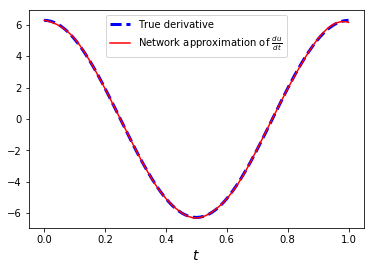

In [7]:
# plot approximation of solution-derivative
der = lambda t: 2 * np.pi * np.cos(2 * np.pi * t)
true_der = [der(t[0]) for t in pts]
ders = dg.solve(pts, fetches='dt')
plt.plot(pts, true_der, 'b--', linewidth=3, label=r'True derivative')
plt.plot(pts, ders, 'r', label=r'Network approximation of $\frac{d u}{d t}$')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

<a id='ex2'></a>
### Poisson equation in $\mathcal{R}^2$ with Dirichlet boundary condition

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 5\sin[\pi(x + y)];
$$

$$
\quad (x, y) \in [0, 1]^2,
$$

$$
u(0, y)=u(x, 0)=u(1, y)=u(x, 1)=1.
$$

In [8]:
# describing pde-problem in pde-dict
pde = {'n_dims': 2,
       'form': lambda u, x, y: D(D(u, x), x) + D(D(u, y), y) - 5 * sin(np.pi * (x + y)),
       'boundary_condition': 1}                       # will be transformed into callable returning 1


config = {'pde': pde,
          'track': {'d2x+d2y': lambda u, x, y: D(D(u, x), x) + D(D(u, y), y)}}    

# uniform sampling scheme (using alias 'u')
s = NumpySampler('u', dim=2)

In [9]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=100, sampler=s, n_iters=1500, bar='notebook')

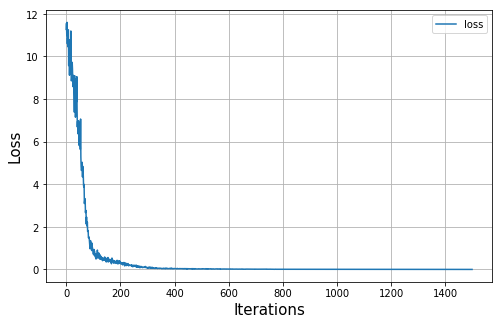

In [10]:
plot_loss(dg.loss)

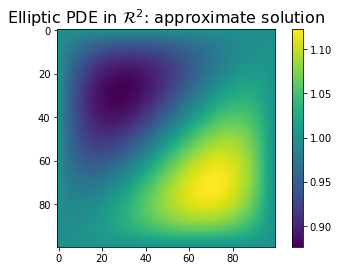

In [11]:
# plot network approximation of a solution
n_el = 100
grid = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))
approxs = dg.solve(grid)

plt.title('Elliptic PDE in $\mathcal{R}^2$: approximate solution', fontdict={'fontsize': 16})
plt.imshow(approxs.reshape(n_el, n_el))
plt.colorbar()
plt.show()

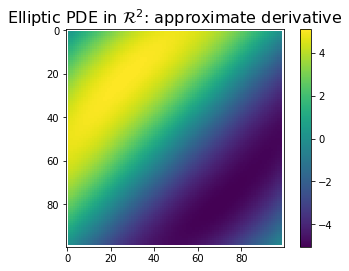

In [12]:
# plot approximation of solution-derivative
ders = dg.solve(grid, fetches='d2x+d2y')
plt.title('Elliptic PDE in $\mathcal{R}^2$: approximate derivative', fontdict={'fontsize': 16})
plt.imshow(ders.reshape(n_el, n_el))
plt.colorbar()
plt.show()

<a id='ex3'></a>

### Heat equation in $\mathcal{R}^2 \times \mathcal{R}$

$$
\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} - \frac{\partial^2 u}{\partial y^2} = 5xy(1 - x)(1 - y) \cos[\pi(x + y)];
$$

$$
(x, y, t) \in [0, 1]^2 \times [0, 1],
$$

$$
u(x, y, 0) = xy(1 - x)(1 - y).
$$

In [13]:
# describing pde-problem in pde-dict
pde = {'n_dims': 3,
       'form': lambda u, x, y, t: (D(u, t) - D(D(u, x), x) - D(D(u, y), y)
                                   - 5 * x * y * (1 - x) * (1 - y) * cos(np.pi * (x + y))),
       'initial_condition': lambda x, y: x * y * (1 - x) * (1 - y)}

# put it together in model-config
config = {'pde': pde}

# uniform sampling scheme
s = NumpySampler('u', dim=3)

In [14]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=200, sampler=s, n_iters=5000, bar='notebook')

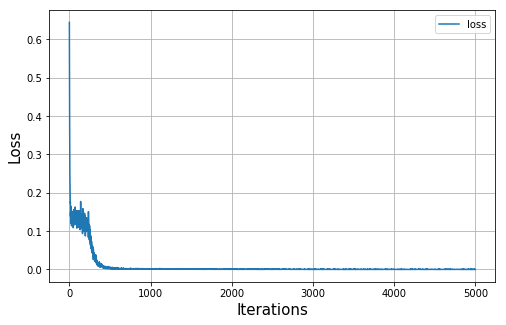

In [15]:
plot_loss(dg.loss)

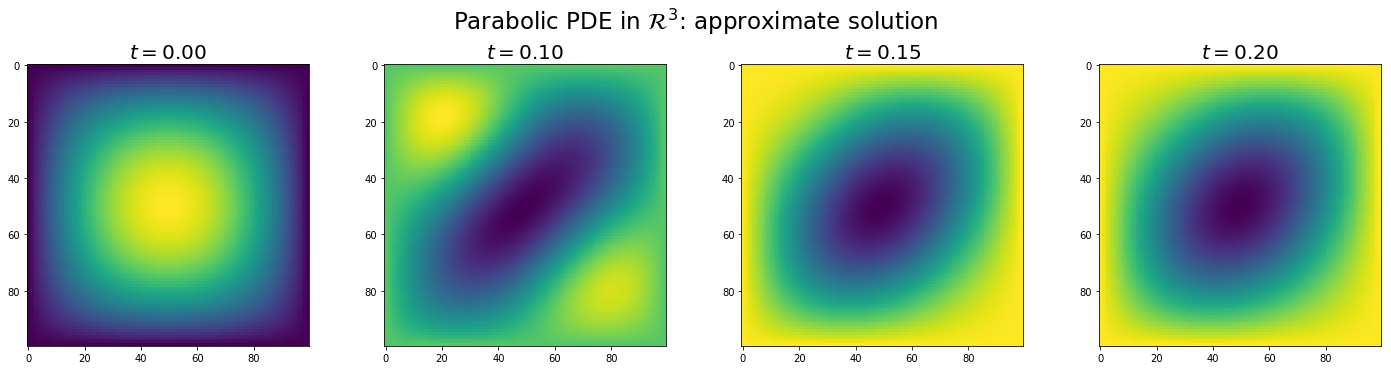

In [16]:
# plot network approximation of a solution
n_sections = 4
timestamps = (0, 0.1, 0.15, 0.2)
n_el = 100
fig, axes = plt.subplots(1, n_sections, figsize=(5 * n_sections, 5))
cart = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))

for i, t_ in enumerate(timestamps):
    grid = np.concatenate([cart, t_ * np.ones(shape=(n_el**2, 1))], axis=1)
    approxs = dg.solve(grid)
    axes[i].imshow(approxs.reshape(n_el, n_el))
    axes[i].set_title('$t=%.2f$' % t_, size=20)
fig.tight_layout()
fig.suptitle('Parabolic PDE in $\mathcal{R}^3$: approximate solution', size=23)
fig.subplots_adjust(top=0.82)
fig.show()

<a id='ex4'></a>

###  Wave equation in $\mathcal{R} \times \mathcal{R}$ (evolution equation of plucked string with fixed ends)

$$
\frac{\partial^2 u}{\partial t^2} - \frac{\partial^2 u}{\partial x^2} = 0,
$$

$$\quad (x, t) \in [0, 1] \times [0, 1],
$$

$$
u(x, 0)=x(1 - x),
$$

$$
\frac{\partial u}{\partial t}(x, 0)= 0.
$$

It is reasonable to set `time_multiplier` to `polynomial` since we know that solution is oscillating endlessly.

In [17]:
# describing pde-problem in pde-dict
pde = {'n_dims': 2,
       'form': lambda u, x, t: D(D(u, t), t) - D(D(u, x), x),
       'initial_condition': [lambda x: x * (1 - x), 0],
       'time_multiplier': 'polynomial'}

# network-architecture
body = {'layout': 'faR fa fa+ f',
        'units': [20, 45, 20, 1],
        'activation': tf.nn.tanh}

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'track': {'dt': lambda u, x, t: D(u, t)}}

# uniform spatial sampling and exponential time-sampling
s = NumpySampler('u') & NumpySampler('e', scale=1).truncate(3.0)

In [18]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=150, sampler=s, n_iters=10000, bar='notebook')

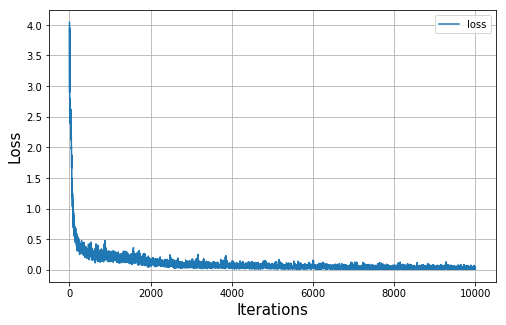

In [19]:
plot_loss(dg.loss)

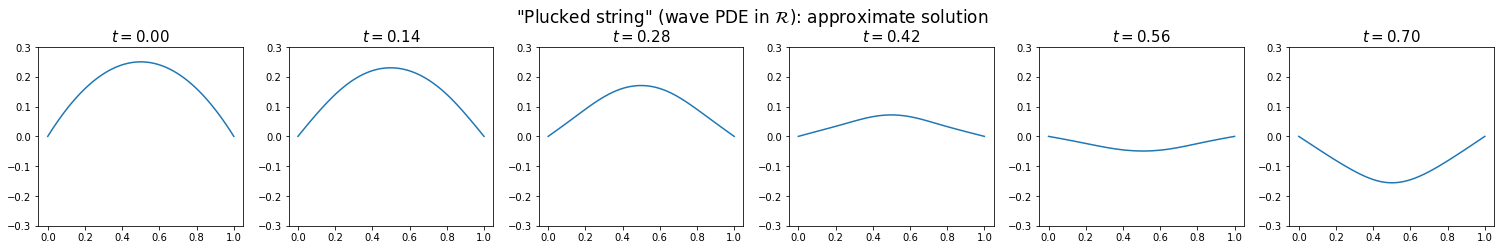

In [20]:
# plot network approximation of a solution
n_sections = 6
timestamps = (0., 0.14, 0.28, 0.42, 0.56, 0.7)
n_el = 100
fig, axes = plt.subplots(1, n_sections, figsize=(3.5 * n_sections, 3.5))
cart = np.linspace(0, 1, n_el).reshape((n_el, 1))

for i, t_ in enumerate(timestamps):
    grid = np.concatenate([cart, t_ * np.ones(shape=(n_el, 1))], axis=1)
    approxs = dg.solve(grid)
    axes[i].plot(cart, approxs.reshape(n_el, ))
    axes[i].set_title('$t=%.2f$' % t_, size=15)
    axes[i].set_ylim(-0.3, 0.3)
    
fig.tight_layout()
fig.suptitle('"Plucked string" (wave PDE in $\mathcal{R}$): approximate solution', size=17)
fig.subplots_adjust(top=0.82)
fig.show()

<a id='ex5'></a>
### Equation with non-constant coefficients in the left-hand side

$$
\frac{1}{f(t)} \frac{\partial u}{\partial t} = 1, \quad
\\
f(t) = 15 + \sin(5t) + 5(t+2)\sin(5t)
\\
u(0) = 30.
$$

In [21]:
# describing pde-problem in pde-dict
f_t = lambda t: ((15 + sin(5 * t))  +  5 * (t + 2) * cos(5 * t))
pde = {'form': lambda u, t: D(u, t) / f_t(t) - 1,
       'n_dims': 1,
       'initial_condition': 15 * 2}

# put it together in model-config
config = {'pde': pde,
          'track': {'dt': lambda u, t: D(u, t)}}

# uniform sampling scheme
s = NumpySampler('u')

In [22]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=100, sampler=s, n_iters=10000, bar='notebook')

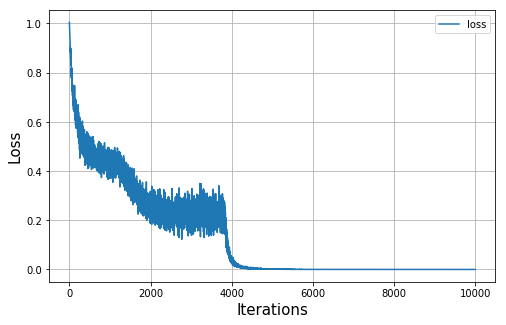

In [23]:
plot_loss(dg.loss)

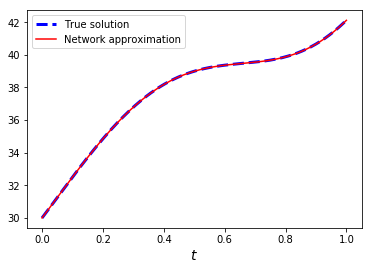

In [24]:
# plot real solution and network approximation
sol = lambda t: (15 + np.sin(5 * t)) * (2 + t)
pts = np.linspace(0, 1, 200).reshape(-1, 1)
approxs = dg.solve(pts)
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b--', linewidth=3, label='True solution')
plt.plot(pts, approxs, 'r', label='Network approximation')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

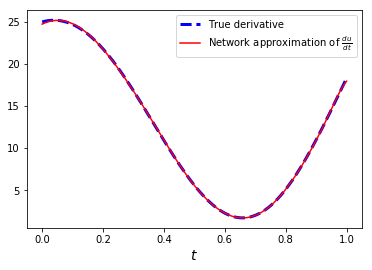

In [25]:
# plot approximation of solution-derivative
der = lambda t: ((15 + np.sin(5 * t))  +  5 * (t + 2) * np.cos(5 * t))
true_der = [der(t[0]) for t in pts]
ders = dg.solve(pts, fetches='dt')
plt.plot(pts, true_der, 'b--', linewidth=3, label=r'True derivative')
plt.plot(pts, ders, 'r', label=r'Network approximation of $\frac{d u}{d t}$')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

<a id='ex6'></a>


### System of two ODEs

With **`PyDEns`** it is also possible to solve system of equations. The basic semantics are the same, but `form`, `initial_condition`, `boundary_condition` are now lists of separate equations or conditions for each function respectively. You also have to provide additional information about the problem by passing `n_funs` and `n_eqns` to PDE-configuration to communicate number of functions and number of equations.

Under the hood, each unknown function is approximated with a neural network: they have common `body` part and separate `head`'s. You can easily control, how much of the computational flow is shared between each approximator by adjusting `body`/`head` configs. 

\begin{cases}
u_1(t) + \dfrac{\partial u_2(t)}{ \partial t} = 0 \\
u_2(t) + \dfrac{\partial u_1(t)}{ \partial t} = 2 \cos(t)
\end{cases}

$$
u_1(0)=0, \quad u_2(0)=1.
$$

It is easy to see that $u_1(t) = \sin(t)$ and $u_2(t) = \cos(t)$ satisfy both system of equations and initial conditions.

In [26]:
pde = {'n_dims': 1, 'n_funs': 2, 'n_eqns': 2,
       'form': [lambda u0, u1, t: u0 + D(u1, t),
                lambda u0, u1, t: u1 + D(u0, t) - 2 * cos(t)],
       'initial_condition': [[0.0],
                             [1.0]],
       'time_multiplier': 'polynomial'}

# Put it all together in model-config
config = {'pde': pde}  

# Uniform sampling scheme
s = NumpySampler('u', dim=1)

In [27]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=50, sampler=s, n_iters=300, bar='notebook')

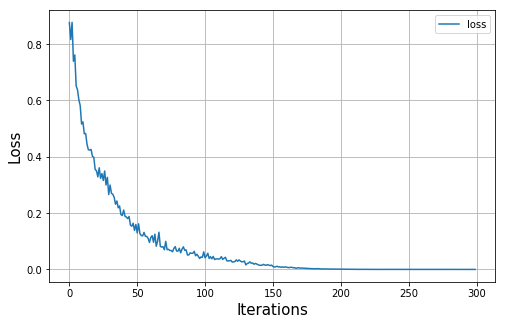

In [28]:
plot_loss(dg.loss)

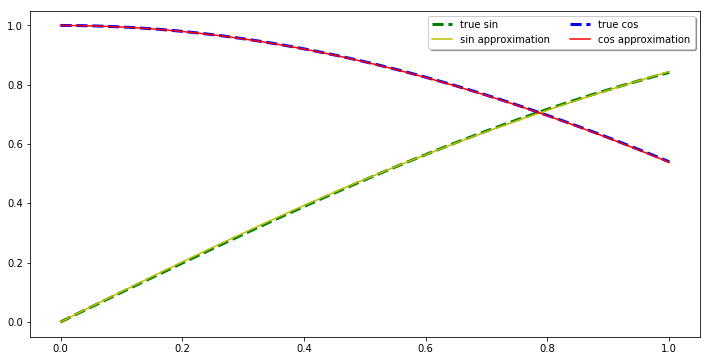

In [29]:
# Plot true solutions and their approximations
n_el = 100
fig, ax = plt.subplots(figsize=(12, 6))
pts = np.linspace(0, 1, n_el).reshape((n_el, 1))

true_sin = [np.sin(t_) for t_ in pts]
approxs_sin = dg.solve(pts)[:, 0]
true_cos = [np.cos(t_) for t_ in pts]
approxs_cos = dg.solve(pts)[:, 1]

plt.plot(pts, true_sin, 'g--', linewidth=3, label='true sin')
plt.plot(pts, approxs_sin.reshape(n_el, ), 'y', label='sin approximation')
plt.plot(pts, true_cos, 'b--',  linewidth=3, label='true cos')
plt.plot(pts, approxs_cos.reshape(n_el, ), 'r', label='cos approximation')

plt.legend(loc='upper right', shadow=True, ncol=2)
fig.show()